# HVP and g-2 in the time-momentum representation with staggered (HISQ) fermions

In [1]:
import sys
import re
import os
import fnmatch
import glob
import h5py
import numpy as np
import matplotlib.pyplot as plt
user=os.environ['USER']
%autosave 60

Autosaving every 60 seconds


## Utils

In [2]:
def jackblocks(data,jacks,omit):
    #loop over timeslices
    nconf=data.shape[0]
    nt=data.shape[1]
    norm=1.0/(nconf-1-len(omit))
    print('omitting '+str(len(omit))+' of '+str(nconf)+' configs')
    for j in range(0,nt):
        #
        # sum over configs
        #
        sum=0.0
        for i in range(0,nconf):
            if i not in omit:
                sum = sum + data[i,j]
        #
        # contruct jacks for time slice j
        #
        n=0
        for i in range(0,nconf):
            if i not in omit:
                jacks[n,j] = sum-data[i,j]
                jacks[n,j] *= norm
                n=n+1
# compute avg and jacknife error from a vector of jacknife blocks
def jack(vec):
    n=vec.shape[0]
    avg=0.0
    # compute average
    for i in range(0,n):
        avg+=vec[i]
    avg = avg/n
    # compute error
    err=0.0
    for i in range(0,n):
        err+=(vec[i]-avg)*(vec[i]-avg)
    err *= (n-1)/n
    err = np.sqrt(err)
    #print(f'{n} blocks, avg+-err= {avg:.4e} +- {err:.4e}')
    return avg, err


def plot_integrand(name, jks, use_ainv=1):
    # outer loop over T, time to integrate up to in bounding method
    # get num jk blks and time size
    num_blks = jks.shape[0]
    time_size = int(jks.shape[1]/2+1)
    if use_ainv==1: # gev-1
        myainv = ainv
        plt.xlim(0,time_size/myainv)
        plt.xlabel('t (GeV$^{-1}$)')
    elif use_ainv==0: #lattice units
        myainv=1
        plt.xlabel('t/a')
        plt.xlim(0,time_size)
    else : #fm
        myainv=1/w0
        plt.xlim(0,time_size*w0)
        plt.xlabel('t (fm)')
    #plt.ylim(-10,100)
    #plt.title(name)
    plt.ylabel('$w$(t)$C$(t)')
    plt.tight_layout()

    corrL = np.zeros((num_blks,time_size))
    for t in range (1,time_size): 
        for n in range (num_blks):
            corrL[n][t] = 5*0.5*(jks[n][t]+jks[n][NT-t])*wt[t]

    for t in range(0,time_size-1):
        tt=corrL[...,t]
        y[t],yerr[t]=jack(tt)
        x[t]=t
    plt.errorbar(x/myainv,y/16*ainv,yerr/16*ainv,label=name,marker='o',markersize=2.5,linestyle='')
    plt.axhline(0)

    plt.savefig(name+"amu-integrand.pdf")

## Global Parameters

In [3]:
fm = 1/0.1973269804

## $64^3$

### Input params

In [4]:
w0oa=1.95180
w0=0.1715/w0oa
dw0oa=0.00070
da=0.1715/w0oa*(0.0009**2/0.1715**2+dw0oa**2/w0oa**2)**0.5
print('lattice spacing, error (fm)=',w0,da)
w0m=w0 -da

NT=96
NS=64
mpi=0.1295
ainv = 1/w0/fm

# read QED kernel w(t) generated in mathematica
wt_file = open(r"64c/wt","r")
# for folded time extent, i.e. include t=96
wt=np.zeros(int(NT/2+1))
for t in range (int(NT/2+1)):
    wt[t] = float(wt_file.readline())

cstart={'h':500,'r':100,'s':100}
cend={'h':4300,'r':2600,'s':1600}
cinc=100
omit=[]
Nconf=0
for series in cstart:
    Nconf+=int((cend[series]-cstart[series])/cinc)
print("a(GeV)=",1/ainv, ', Nconf=', Nconf)

lattice spacing, error (fm)= 0.0878676093862076 0.00046218839138563174
a(GeV)= 0.4452893831755387 , Nconf= 78


In [5]:
clma=np.load('corrLma_jks.npy')
clmasub=np.load('corrLmaSub_jks.npy')
capprox=np.load('corrApprox_jks.npy')
cexact=np.load('corrExact_jks.npy')
csub=np.load('corrSub_jks.npy')

In [6]:
corrtot_jk_blks = capprox+cexact-csub+clma-clmasub

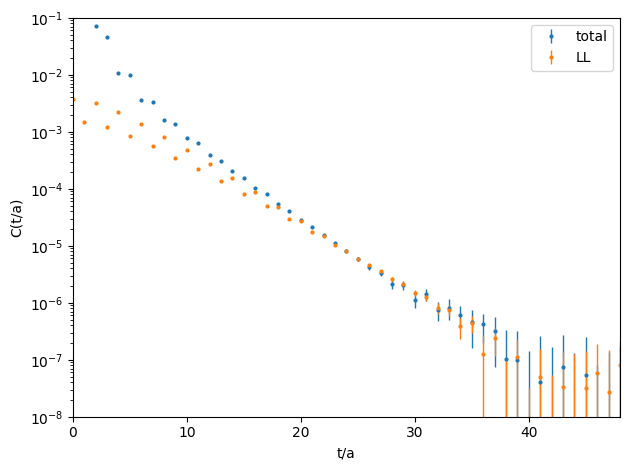

In [8]:
#plt.rc('axes', labelsize=20)
plt.ylim(1e-8,1e-1)
plt.xlim(0,NT/2)
plt.yscale("log")
plt.xlabel('t/a')
plt.ylabel('C(t/a)')
plt.tight_layout()

x=np.zeros(NT)
y=np.zeros(NT)
yerr=np.zeros(NT)
for t in range(0,NT):
    tt=corrtot_jk_blks[...,t]
    y[t],yerr[t]=jack(tt)
    x[t]=t
plt.errorbar(x,y,yerr,linestyle='',linewidth=1,marker='o',markersize=2,label='total')
for t in range(0,NT):
    tt=clma[...,t]
    y[t],yerr[t]=jack(tt)
    x[t]=t
plt.errorbar(x,y,yerr,linestyle='',linewidth=1,marker='o',markersize=2,label='LL')
plt.legend()

### full $a_\mu$ integrand

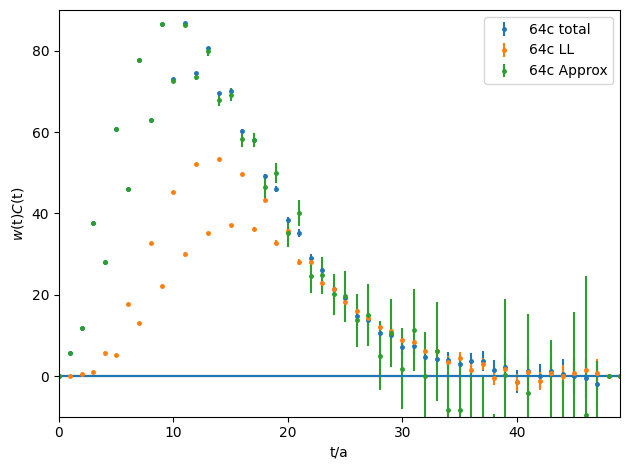

In [9]:
plot_integrand('64c total',corrtot_jk_blks,0)
plot_integrand('64c LL',clma,0)
#plot_integrand('64c Exact',cexact,0)
plot_integrand('64c Approx',capprox,0)
plt.ylim(-10,90)
plt.legend()

### windows

1. Implement the window step function and repeat the above plot for the $t_1=0.4$ fm SD window and the 0.4-1 fm ID windows 

2. Compute the corresponding values for $a_\mu$